# Models

Build models to see how much each feature contributes to productivity

- Models
    - LinearRegression
    - ExplainableBoostingRegressor
- Features
    - Education
    - Population
    - R&D Expenditure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/interim/dataset.csv')
df.head()

,year,GEO,Compensation of employees per hour worked (Euro),Compensation per employee (Euro),education,population,rd_expenditure
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06
1,2011,Belgium,35.1,50593.5,47.857143,11000638,2.17
2,2012,Belgium,36.2,52178.2,48.242857,11075889,2.28
3,2013,Belgium,37.2,53452.5,49.242857,11137974,2.33
4,2014,Belgium,37.6,53965.2,50.285714,11180840,2.37


## Scale Features

In [3]:
scaler = StandardScaler()
df['per_hour_worked'] = scaler.fit_transform(df[['Compensation of employees per hour worked (Euro)']])
df['per_employee'] = scaler.fit_transform(df[['Compensation per employee (Euro)']])
df['education'] = scaler.fit_transform(df[['education']])
df['population'] = scaler.fit_transform(df[['population']])
df['rd_expenditure'] = scaler.fit_transform(df[['rd_expenditure']])
df[['per_hour_worked', 'per_employee', 'education', 'population', 'rd_expenditure']].corr()

,per_hour_worked,per_employee,education,population,rd_expenditure
per_hour_worked,1.000000,0.990948,0.307323,0.112138,0.580168
per_employee,0.990948,1.000000,0.306327,0.107771,0.575635
education,0.307323,0.306327,1.000000,-0.011982,0.480950
population,0.112138,0.107771,-0.011982,1.000000,0.214731
rd_expenditure,0.580168,0.575635,0.480950,0.214731,1.000000


## Capturing Trends

There are several ways to capture trends.

- Move data to n years (`shift`)
- Take the mean of n years
- ...

In [4]:
features = ['education', 'population', 'rd_expenditure']
shift_range = [1]
for feature in features:
    for shift in shift_range:
        df[f'{feature}_shift_{shift}'] = df.sort_values('year').groupby(['GEO'])[feature].shift(shift)
        
df = df[df['year'] > 2010]
df = df.dropna()

df.head()

,year,GEO,Compensation of employees per hour worked (Euro),Compensation per employee (Euro),education,population,rd_expenditure,per_hour_worked,per_employee,education_shift_1,population_shift_1,rd_expenditure_shift_1
1,2011,Belgium,35.1,50593.5,-0.988163,-0.213463,0.755741,1.056851,0.985691,-0.918085,-0.220912,0.630114
2,2012,Belgium,36.2,52178.2,-0.943113,-0.209975,0.881368,1.139885,1.070517,-0.988163,-0.213463,0.755741
3,2013,Belgium,37.2,53452.5,-0.826317,-0.207098,0.938471,1.215371,1.138727,-0.943113,-0.209975,0.881368
4,2014,Belgium,37.6,53965.2,-0.704515,-0.205111,0.984154,1.245565,1.166171,-0.826317,-0.207098,0.938471
5,2015,Belgium,37.8,54043.8,-0.834660,-0.202496,1.052678,1.260662,1.170378,-0.704515,-0.205111,0.984154


## LinearRegression

$$
y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$

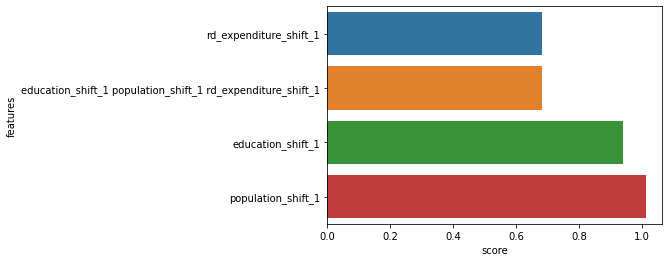

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train(features):
    x = df[features]
    y = df[['per_hour_worked']]
    score_on_train = []
    score_on_test = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = LinearRegression()
        model.fit(x_train, y_train)
        score_on_train.append(mean_squared_error(y_train, model.predict(x_train)))
        score_on_test.append(mean_squared_error(y_test, model.predict(x_test)))

    return np.mean(score_on_test)

features = [
    ['education_shift_1'],
    ['population_shift_1'],
    ['rd_expenditure_shift_1'],
    ['education_shift_1', 'population_shift_1', 'rd_expenditure_shift_1']
]
scores = [train(f) for f in features]
result = pd.DataFrame({
    'features': [' '.join(f) for f in features],
    'score': scores
}).sort_values(by='score')
sns.barplot(data=result, x='score', y='features')

## Visualize Feature Importance

['education_shift_1', 'population_shift_1', 'rd_expenditure_shift_1']
[[0.05741559 0.0249344  0.56837448]]


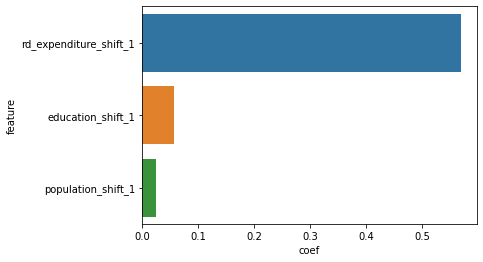

In [6]:
features = ['education_shift_1', 'population_shift_1', 'rd_expenditure_shift_1']
x = df[features]
y = df[['per_hour_worked']]

model = LinearRegression()
model.fit(x, y)

print(features)
print(model.coef_)

result = pd.DataFrame({
    'feature': features,
    'coef': model.coef_[0]
}).sort_values(by=['coef'], ascending=False)
sns.barplot(data=result, y='feature', x='coef')

## ExplainableBoostingRegressor (from InterpretML)

EBM is a generalized additive model formalized as follows.

$$
g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ij}(x_i,x_j)
$$

EBM learns the best feature function $f_j$ for each feature to show how each feature contributes to the model's prediction for the problem. EBM can also automatically detect and include pairwise interaction terms.

Paper: https://arxiv.org/pdf/1909.09223.pdf

### Global Explanation

In [7]:
from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(x_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
interpret.show(ebm_global)

<!-- http://127.0.0.1:7997/5003776976/ -->

### Local Explanation

In [8]:
ebm_local = ebm.explain_local(x_test[:5], y_test[:5], name='EBM')
interpret.show(ebm_local)

<!-- http://127.0.0.1:7997/5045279632/ -->

In [9]:
from interpret.glassbox import LinearRegression
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(x_test, y_test, name='Linear Regression')
interpret.show(ebm_perf)

<!-- http://127.0.0.1:7997/5068892816/ -->